# 2. Missing Values & Dimension Reduction

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
warnings.filterwarnings('ignore')

### References 

Reducing Data Size : https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054

# Reduce Data Size

parquet : https://uiandwe.tistory.com/1322  

In [4]:
train_r = pd.read_parquet("C:/Users/kimch/Desktop/American Express/train.parquet")

In [5]:
labels = pd.read_csv("C:/Users/kimch/Desktop/American Express/train_labels.csv")

In [7]:
train = train_r.merge(labels, right_on = 'customer_ID', left_on = "customer_ID")

In [8]:
train.dtypes
# 이미 parquet 파일이라 그런가 float32, int8 형식으로 거의 다 바뀌어져 있었음

customer_ID     object
S_2             object
P_2            float32
D_39             int16
B_1            float32
B_2            float32
R_1            float32
S_3            float32
D_41           float32
B_3            float32
D_42           float32
D_43           float32
D_44              int8
B_4              int16
D_45           float32
B_5            float32
R_2               int8
D_46           float32
D_47           float32
D_48           float32
D_49             int16
B_6            float32
B_7            float32
B_8            float32
D_50           float32
D_51              int8
B_9            float32
R_3               int8
D_52           float32
P_3            float32
B_10           float32
D_53           float32
S_5            float32
B_11           float32
S_6               int8
D_54           float32
R_4               int8
S_7            float32
B_12           float32
S_8              int16
D_55           float32
D_56           float32
B_13           float32
R_5        

In [9]:
# customer_ID -> parquet 파일이라서 그런가 에러 뜸..
train = train.astype({"customer_ID":"int64"})

In [13]:
# time stamp
train["S_2"] = pd.to_datetime(train.S_2, format="%Y-%m-%d")

# Missing Values

In [14]:
missing_percentage = pd.DataFrame(columns=['column', 'null_percentage'])

for col in train.columns:
    p = round((train[col].isnull().sum() / train[col].shape[0]), 2)
    missing_percentage =  missing_percentage.append(pd.DataFrame([[col, p]], columns=['column', 'null_percentage']), ignore_index=True)

missing_percentage.set_index("column", inplace=True)
missing_percentage = missing_percentage.sort_values(by="null_percentage", ascending=False)
missing_percentage = missing_percentage[missing_percentage["null_percentage"] > 0]
missing_percentage

,null_percentage
column,
D_88,1.00
B_42,0.99
D_110,0.99
D_73,0.99
B_39,0.99
D_134,0.96
B_29,0.93
D_132,0.90
D_76,0.89


### 결측치 처리 가이드 라인
#### 가이드라인 1 (https://wooono.tistory.com/103)
-10% 미만 : 삭제(결측치 있는 행) or 대치(imputation)  
-10% ~ 50% : regression or model based imputation  
-50% 이상 : 해당 칼럼(변수) 자체 제거 
  
#### 가이드라인 2 (https://eda-ai-lab.tistory.com/14)
-10% 미만 : 삭제(결측치 있는 행) or 대치(imputation)  
-10% 이상 20% 미만 : hot deck, regression, model based method  
-20% 이상: model based method, regression

In [15]:
# 결측치 비율: 50% 이상 - 해당 칼럼(변수) 자체 제거
train_p = train.drop(columns=["D_88", "B_42", "D_110", "D_73", "B_39", "D_134", "B_29", "D_132", "D_76", "D_42", "D_142", "D_53", "B_17",
                              "D_50", "D_105", "D_56", "S_9"])

In [ ]:
# 결측치 비율: 10% 미만 - 삭제(결측치 있는 행) or 대치(imputation) -> 삭제
# P_3, D_69, D_115, D_118, D_119, D_121, D_55, D_131, D_141, D_130, D_104, R_27, D_128, D_102, B_13, D_133, D_144, D_52, P_2

In [16]:
train_p = train_p.dropna(subset=["P_3", "D_69", "D_115", "D_118", "D_119", "D_121", "D_55", "D_131", "D_141", "D_130", "D_104", "R_27", "D_128", "D_102", "B_13", "D_133", "D_144", "D_52", "P_2"])

In [ ]:
# 결측치 비율 : 10% ~ 50% - 시계열 데이터이기에 시간별로 보간하는 interpolate 사용 -> 다 채워지는건 아닌건가봄,,
# D_77, D_43, S_27, D_46, S_3, S_7, D_62, D_48, D_61

In [22]:
train_fillna = train_p.set_index('S_2')
train_fillna = train_fillna.interpolate(method="time")

In [25]:
train_fillna.head()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,B_13,R_5,D_58,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
S_2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-09,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,4,0.008207,0,0.207334,0.736463,0.096219,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.118075,0,0.158612,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0,0.652984,0,-1,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,0.0,1,1,0.004327,0.0,NaN,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,-1,1.0,0.210060,0.676922,0,1,0.238250,0,5,0.232120,0.236266,0,0.702280,3,0,16,0,2,1,1.007819,1,0,0.0,0.0,0.004345,0,-1,-1,-1,-1,0,0,0.0,0,0.000610,0,0
2017-04-07,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,4,0.008373,0,0.202778,0.720886,0.099804,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.118737,0,0.148459,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0,0.647093,0,-1,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,0.0,1,1,0.004203,0.0,NaN,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,-1,1.0,0.184093,0.822281,0,1,0.247217,0,5,0.243532,0.241885,0,0.707017,3,0,16,0,2,1,1.004333,1,0,0.0,0.0,0.007495,0,-1,-1,-1,-1,0,0,0.0,0,0.005492,0,0
2017-05-28,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,4,0.009355,0,0.206629,0.738044,0.134073,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.114534,0,0.139504,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0,0.645819,0,-1,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,0.0,1,1,0.001782,0.0,NaN,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,-1,1.0,0.154837,0.853498,0,1,0.239867,0,5,0.240768,0.239710,0,0.704843,3,0,16,0,2,1,1.007831,1,0,0.0,0.0,0.009227,0,-1,-1,-1,-1,0,0,0.0,0,0.006986,0,0
2017-06-13,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,NaN,0,4,0.723997,0.166782,0,0.323271,0.530929,0.135586,-1,0.083720,0.049253,0.0,4,0.006782,0,0.208214,0.741813,0.134437,0.030063,0.009667,0,1

In [26]:
train_fillna2 = train_fillna.reset_index()

In [30]:
missing_percentage = pd.DataFrame(columns=['column', 'null_percentage'])

for col in train_fillna.columns:
    p = round((train_fillna[col].isnull().sum() / train_fillna[col].shape[0]), 2)
    missing_percentage =  missing_percentage.append(pd.DataFrame([[col, p]], columns=['column', 'null_percentage']), ignore_index=True)

missing_percentage.set_index("column", inplace=True)
missing_percentage = missing_percentage.sort_values(by="null_percentage", ascending=False)
missing_percentage[missing_percentage["null_percentage"]>0]

,null_percentage
column,


In [ ]:
missing = pd.DataFrame(columns=['column', 'null_sum'])

for col in train_fillna_drop.columns:
    n = train_fillna_drop[col].isnull().sum()
    missing =  missing.append(pd.DataFrame([[col, n]], columns=['column', 'null_sum']), ignore_index=True)

missing.set_index("column", inplace=True)
missing = missing.sort_values(by="null_sum", ascending=False)
missing[missing["null_sum"]>0]

# 결과 -> 퍼센트로 치면 0이지만 결측치 D_43: 19개, D_77: 11개

# Dimension Reduction

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
deliquency = train_fillna.filter(regex="D_")
deliquency = pd.concat([deliquency, train_fillna[["target"]]], axis=1)

In [ ]:
# 메모리 에러남 -> 상관계수 겹치는 것 많을 것 같은디
d_corr = deliquency.corr()
 
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(d_corr, annot=True, fmt=".1f", xticklabels=d_corr.columns, yticklabels=d_corr.columns, cmap="Blues", ax=ax)

In [35]:
spend = train_fillna.filter(regex="S_")
spend = pd.concat([spend, train_fillna[["target"]]], axis=1)

<AxesSubplot:>

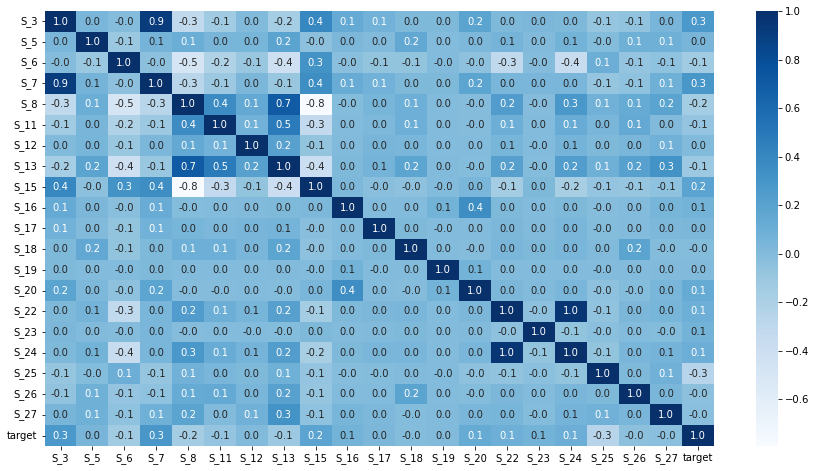

In [42]:
s_corr = spend.corr()
 
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(s_corr, annot=True, fmt=".1f", xticklabels=s_corr.columns, yticklabels=s_corr.columns, cmap="Blues", ax=ax)

S_22 - S_24 : 상관계수 1.0  
S_3 - S_7 : 상관계수 0.9

In [44]:
payment = train_fillna.filter(regex="P_")
payment = pd.concat([payment, train_fillna[["target"]]], axis=1)

<AxesSubplot:>

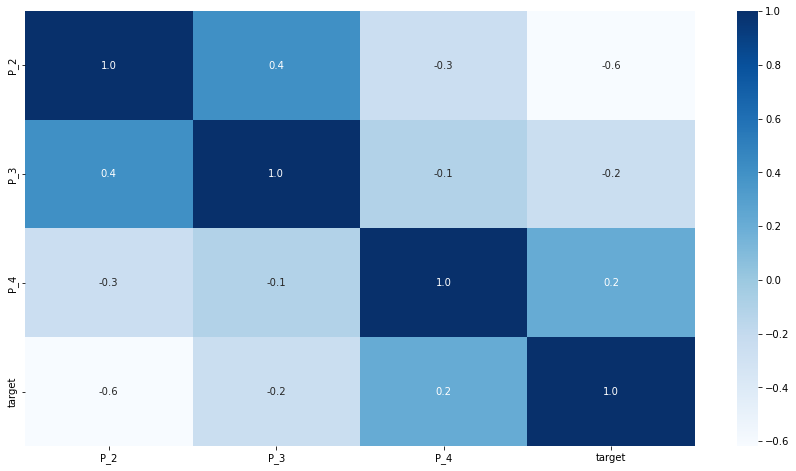

In [45]:
p_corr = payment.corr()
 
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(p_corr, annot=True, fmt=".1f", xticklabels=p_corr.columns, yticklabels=p_corr.columns, cmap="Blues", ax=ax)

In [50]:
balance = train_fillna.filter(regex="B_")
balance = pd.concat([balance, train_fillna[["target"]]], axis=1)

<AxesSubplot:>

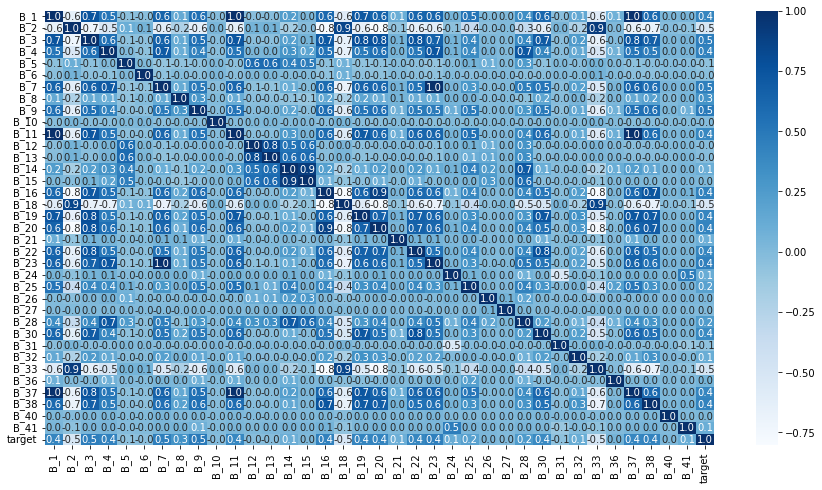

In [53]:
b_corr = balance.corr()
 
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(b_corr, annot=True, fmt=".1f", xticklabels=b_corr.columns, yticklabels=b_corr.columns, cmap="Blues", ax=ax)

B_1 - B_11 : 1.0  
B_1 - B_37 : 1.0  
B_2 - B_33 : 0.9  
B_7 - B_23 : 1.0  
B_11 - B_37 : 1.0  
B_14 - B_15 : 0.9  
B_16 - B_20 : 0.9  
B_2 - B_18 : 0.9  

In [54]:
risk = train_fillna.filter(regex="R_")
risk =pd.concat([risk, train_fillna[["target"]]], axis=1)

<AxesSubplot:>

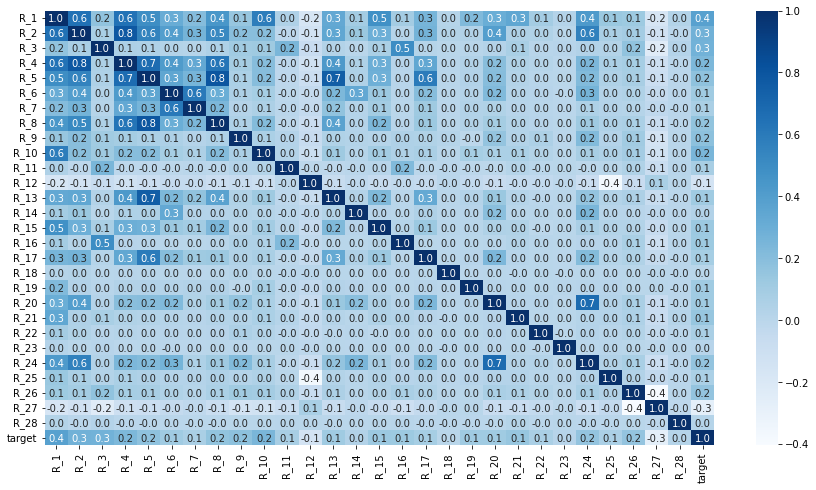

In [56]:
r_corr = risk.corr()
 
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(r_corr, annot=True, fmt=".1f", xticklabels=r_corr.columns, yticklabels=r_corr.columns, cmap="Blues", ax=ax)

S_7, S_24 제거  
B_11, B_37, B_33, B_18, B_23, B_37, B_15, B_20 제거

In [58]:
train_fillna_drop = train_fillna.drop(columns=['S_7', "S_24", "B_11", "B_37", "B_33", "B_18", "B_23", "B_37", "B_15", "B_20"])

In [59]:
train_fillna_drop.shape

(4957212, 164)

cf: (5531451, 191) -> (4957212, 164)